# Import Libraries

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
!pip install kneed
from kneed import KneeLocator
import plotly.express as px

In [84]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [85]:
# describe data
df.describe()

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,2.250000e+02,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


The dataset shows very large variation across countries, with populations ranging from under a thousand to over 1.4 billion and COVID-19 cases ranging from only a few to more than 8 million. The high standard deviations, often larger than the means, indicate strong skewness, meaning a small number of highly affected countries dominate the global totals. The median death percentage (CFR) is around 1.03 percent, suggesting that for most countries fatality rates cluster near 1 percent even though a few outliers reach as high as 18 percent.

In [86]:
# show unique values from dataset
unique_values = {col: df[col].unique() for col in df.columns}
display(unique_values)

{'Country': array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
        'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
        'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
        'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
        'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
        'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei ',
        'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia',
        'Cameroon', 'Canada', 'CAR', 'Caribbean Netherlands',
        'Cayman Islands', 'Chad', 'Channel Islands', 'Chile', 'China',
        'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
        'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', 'Denmark',
        'Djibouti', 'Dominica', 'Dominican Republic',
        'Democratic Republic of the Congo', 'Ecuador', 'Egypt',
        'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
        'Eswatini', 'Ethiopia', 'Faeroe I

In [87]:
# drop other names column because it is irrelevant
df= df.drop(columns=["Other names"])

In [88]:
# Rename columns because it is hard to read
df.rename(columns={'Tot\xa0Cases//1M pop': 'Tot Cases//1M pop', 'Tot\xa0Deaths/1M pop': 'Tot Deaths/1M pop'}, inplace=True)

In [89]:
fig = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",
    color="Continent",
    hover_name="Country",
    title="World Map of Countries by Continent",
    projection="natural earth",   # <-- Natural Earth projection
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.show()


The map displays the global distribution of countries grouped by continent using the Natural Earth projection. Each continent is clearly distinguished through color coding, making geographic patterns and regional boundaries easy to observe. This visualization helps confirm that the dataset correctly categorizes each country based on its continental region.

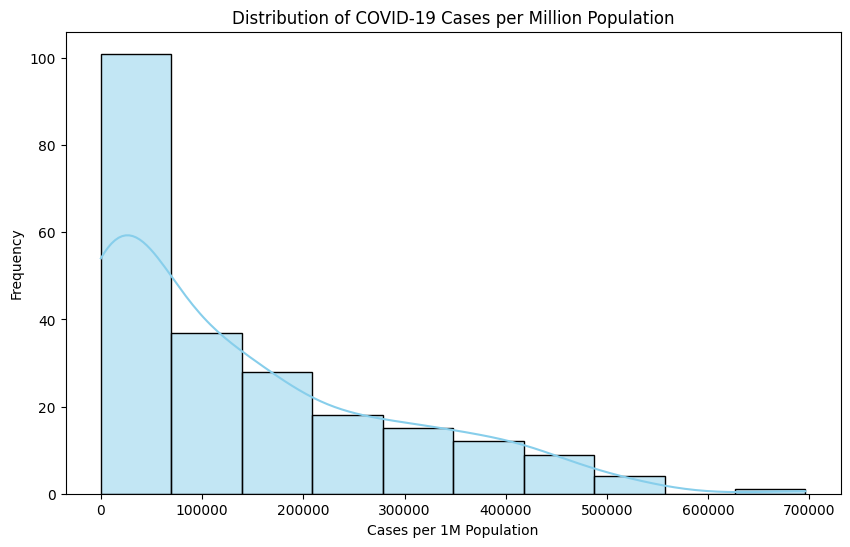

In [90]:
plt.figure(figsize=(10,6))
sns.histplot(
    df["Tot Cases//1M pop"],
    kde=True,
    color="skyblue"
)
plt.title("Distribution of COVID-19 Cases per Million Population")
plt.xlabel("Cases per 1M Population")
plt.ylabel("Frequency")
plt.show()

The distribution shows that most countries have relatively low to moderate COVID-19 case rates per million population, with the highest concentration appearing in the lower range. The long right tail indicates a strong positive skew, meaning a small number of countries experienced extremely high infection rates compared to the rest. This pattern highlights that the global impact of COVID-19 was uneven, with only a few nations showing exceptionally intense outbreaks relative to population size.

In [91]:
# ============================================
# 0. DUPLICATE DATASET
# ============================================
df_encoded = df.copy()

import pprint

# ============================================
# 1. ORDINAL ENCODING (Continent)
# ============================================
# Define ranking order for Continents
continent_map = {
    "Africa": 0,
    "Asia": 1,
    "Europe": 2,
    "Latin America and the Caribbean": 3,
    "Northern America": 4,
    "Oceania": 5
}

# Apply manual mapping
df_encoded["Continent"] = df_encoded["Continent"].map(continent_map)


# ============================================
# 2. Build mapping dictionary for documentation
# ============================================
encode_dict = {
    "Continent": continent_map
}

# ============================================
# 3. Show mapping result
# ============================================
pprint.pprint(encode_dict)

# ============================================
# 4. Show encoded dataset sample
# ============================================
df_encoded.sample(5)


{'Continent': {'Africa': 0,
               'Asia': 1,
               'Europe': 2,
               'Latin America and the Caribbean': 3,
               'Northern America': 4,
               'Oceania': 5}}


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
35,Canada,CAN,38321435,4,3499226,37690,91312,984,1.077095
111,Lebanon,LBN,6771939,1,1092995,10315,161401,1523,0.943737
172,Saint Pierre Miquelon,SPM,5744,4,1957,1,340703,174,0.051099
50,Curaçao,CUW,165268,3,40671,267,246091,1616,0.656487
17,Belarus,BLR,9443882,2,965322,6844,102217,725,0.708986


# Scaling the Data

In [92]:
from sklearn.preprocessing import StandardScaler

# ============================================
# 1. Select ONLY continuous numerical columns
# ============================================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

# ============================================
# 2. Initialize the StandardScaler
# ============================================
scaler = StandardScaler()

# ============================================
# 3. Fit + transform the selected numerical columns
# ============================================
df_scaled = df_encoded.copy()   # duplicate encoded dataset
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# ============================================
# 4. Show sample output
# ============================================
df_scaled.head()


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,AFG,0.038789,1,-0.276449,-0.204571,-0.915487,-0.759994,1.651243
1,Albania,ALB,-0.231774,2,-0.263220,-0.247798,-0.287081,0.099982,-0.097285
2,Algeria,DZA,0.073154,0,-0.264347,-0.212815,-0.905275,-0.791845,0.657760
3,Andorra,AND,-0.251891,2,-0.295431,-0.282336,2.623123,0.736164,-0.611015
4,Angola,AGO,-0.003016,0,-0.287281,-0.264265,-0.926078,-0.873149,0.271204


# Agglomerative Clustering

In [93]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
from sklearn.cluster import AgglomerativeClustering

# ============================================
# 2. SELECT BEST NUMBER OF CLUSTERS (example: k = 3)
#    Choose based on your silhouette score plot
# ============================================
best_k = 3   # change this based on your silhouette result

# ============================================
# 3. FIT AGGLOMERATIVE CLUSTERING MODEL
# ============================================
agglo_final = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='single'   # same linkage as your silhouette test
)

# ============================================
# 4. GENERATE CLUSTER LABELS ON SCALED DATA
# ============================================
# Select only the numerical and encoded 'Continent' columns for clustering
clustering_data = df_scaled[numerical_cols + ['Continent']]
cluster_labels = agglo_final.fit_predict(clustering_data)

# ============================================
# 5. ADD CLUSTER RESULTS BACK TO DATAFRAME
# ============================================
df_scaled["Cluster"] = cluster_labels

# ============================================
# 6. SHOW SAMPLE OUTPUT
# ============================================
df_scaled.head()


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Cluster
0,Afghanistan,AFG,0.038789,1,-0.276449,-0.204571,-0.915487,-0.759994,1.651243,2
1,Albania,ALB,-0.231774,2,-0.263220,-0.247798,-0.287081,0.099982,-0.097285,2
2,Algeria,DZA,0.073154,0,-0.264347,-0.212815,-0.905275,-0.791845,0.657760,2
3,Andorra,AND,-0.251891,2,-0.295431,-0.282336,2.623123,0.736164,-0.611015,2
4,Angola,AGO,-0.003016,0,-0.287281,-0.264265,-0.926078,-0.873149,0.271204,2


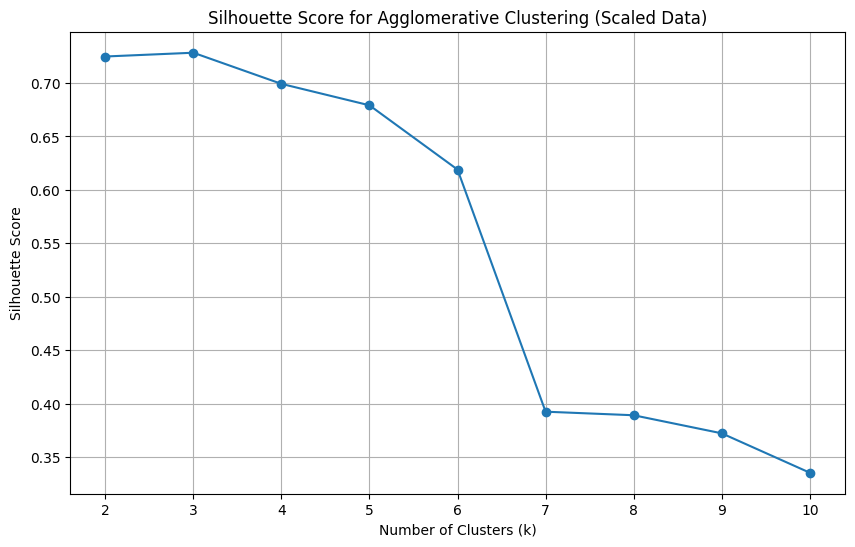

In [94]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# ============================================
# 2. INITIALIZE STORAGE FOR SILHOUETTE SCORES
# ============================================
silhouette_scores = []

# Select only the numerical and encoded 'Continent' columns for clustering
clustering_data = df_scaled[numerical_cols + ['Continent']]

# ============================================
# 3. LOOP THROUGH POSSIBLE CLUSTER COUNTS (k = 2 to 10)
# ============================================
for k in range(2, 11):

    # Create Agglomerative model for this k
    agglo_model = AgglomerativeClustering(
        n_clusters=k,
        linkage='single'   # same linkage as your requirement
    )

    # Fit on SCALED data (using only numerical columns)
    cluster_labels = agglo_model.fit_predict(clustering_data)

    # Compute silhouette score
    silhouette_avg = silhouette_score(clustering_data, cluster_labels)

    # Store the score
    silhouette_scores.append(silhouette_avg)

# ============================================
# 4. PLOT THE SILHOUETTE SCORES
# ============================================
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Agglomerative Clustering (Scaled Data)")
plt.grid(True)
plt.show()


The silhouette plot shows that the highest clustering quality occurs at k = 3, where the silhouette score reaches its peak. Scores for k = 2 and k = 4 are also relatively high, but performance steadily declines as the number of clusters increases, indicating that adding more clusters reduces cohesion and separation between groups. This suggests that the dataset naturally forms around three well-defined clusters, and using more than six clusters leads to unstable or poorly separated groupings.

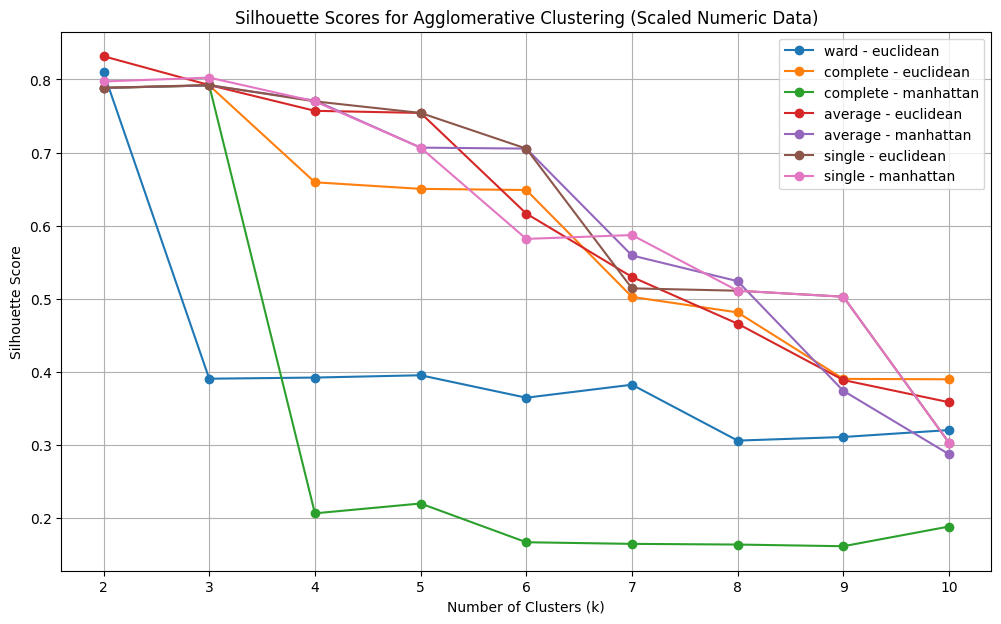

===== BEST MODEL CONFIGURATION (SCALED NUMERIC DATA) =====
Best Silhouette Score     : 0.8318263727111447
Optimal Number of Clusters: 2
Optimal Linkage Method    : average
Optimal Distance Metric   : euclidean


In [95]:
# ============================================
# 1. IMPORT LIBRARIES
# ============================================
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ============================================
# 2. DEFINE NUMERICAL COLUMNS (MUST MATCH SCALING STEP)
# ============================================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

# Work only with numeric, scaled features
X = df_scaled[numerical_cols]

# ============================================
# 3. SETUP: RANGE OF CLUSTERS + METHODS TO TEST
# ============================================
range_n_clusters = range(2, 11)

linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = None
best_linkage = None
best_metric = None

results_for_plotting = []


# ============================================
# 4. LOOP THROUGH LINKAGE–METRIC COMBINATIONS
# ============================================
for linkage_method in linkage_methods:
    for metric in metrics:

        # Ward only supports Euclidean distance
        if linkage_method == 'ward' and metric == 'manhattan':
            continue

        current_scores = []

        for n_clusters in range_n_clusters:

            model = AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage=linkage_method,
                metric=metric
            )

            # Fit on NUMERIC SCALED DATA ONLY
            labels = model.fit_predict(X)

            # Compute silhouette score
            silhouette_avg = silhouette_score(X, labels)
            current_scores.append(silhouette_avg)

            # Track best configuration
            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric

        # Save scores for this linkage–metric combo
        results_for_plotting.append({
            "linkage": linkage_method,
            "metric": metric,
            "scores": current_scores
        })


# ============================================
# 5. VISUALIZE SILHOUETTE SCORES
# ============================================
plt.figure(figsize=(12, 7))

for result in results_for_plotting:
    label = f"{result['linkage']} - {result['metric']}"
    plt.plot(
        range_n_clusters,
        result["scores"],
        marker='o',
        label=label
    )

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering (Scaled Numeric Data)")
plt.legend()
plt.grid(True)
plt.show()


# ============================================
# 6. PRINT BEST MODEL CONFIGURATION
# ============================================
print("===== BEST MODEL CONFIGURATION (SCALED NUMERIC DATA) =====")
print(f"Best Silhouette Score     : {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method    : {best_linkage}")
print(f"Optimal Distance Metric   : {best_metric}")


The plot compares silhouette scores across multiple linkage–metric combinations and shows that the best clustering performance occurs at k = 2, specifically using average linkage with Euclidean distance, where the silhouette score reaches approximately 0.83. Most configurations show a clear decline in silhouette scores as the number of clusters increases, indicating that the data does not naturally separate into many groups. The consistently high scores for k = 2 across several methods suggest that the dataset forms two well-defined and well-separated clusters, while additional clusters introduce overlap and reduce clustering quality.

In [96]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# =========================================
# Select ONLY numerical scaled columns
# (same columns used during scaling)
# =========================================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

X = df_scaled[numerical_cols]


# =========================================
# Build BEST model from previous search
# (using results from df_scaled silhouette analysis)
# =========================================
agglo_best_scaled = AgglomerativeClustering(
    n_clusters=best_n_clusters,   # from silhouette comparison
    linkage=best_linkage,         # e.g. 'average'
    metric=best_metric            # e.g. 'euclidean'
)

# =========================================
# Fit model on SCALED NUMERIC DATA
# =========================================
y_hc_best_scaled = agglo_best_scaled.fit_predict(X)

# =========================================
# Evaluate silhouette score
# =========================================
ss_best_scaled = silhouette_score(X, y_hc_best_scaled)
print("Silhouette Score (Best Model / Scaled Data):", ss_best_scaled)

# =========================================
# Attach cluster labels back to dataframe
# =========================================
df_scaled["Agglo_Scaled"] = y_hc_best_scaled

# Optional: preview updated dataframe
df_scaled.head()


Silhouette Score (Best Model / Scaled Data): 0.8318263727111447


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Cluster,Agglo_Scaled
0,Afghanistan,AFG,0.038789,1,-0.276449,-0.204571,-0.915487,-0.759994,1.651243,2,0
1,Albania,ALB,-0.231774,2,-0.263220,-0.247798,-0.287081,0.099982,-0.097285,2,0
2,Algeria,DZA,0.073154,0,-0.264347,-0.212815,-0.905275,-0.791845,0.657760,2,0
3,Andorra,AND,-0.251891,2,-0.295431,-0.282336,2.623123,0.736164,-0.611015,2,0
4,Angola,AGO,-0.003016,0,-0.287281,-0.264265,-0.926078,-0.873149,0.271204,2,0


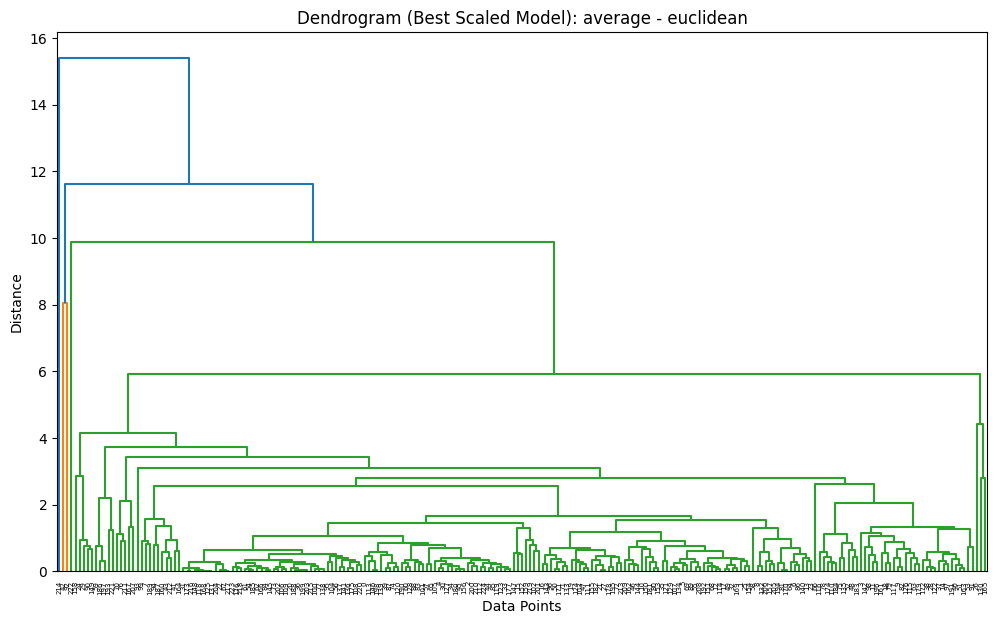

In [97]:
# ============================
# MODEL 1 — Best Parameters (Scaled)
# ============================

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt

# ============================
# Select ONLY numeric scaled features
# ============================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

X = df_scaled[numerical_cols]

# ============================
# SciPy does NOT accept "manhattan"; convert it to "cityblock"
# Ward always forces Euclidean
# ============================
if best_linkage == "ward":
    metric_for_scipy = "euclidean"
else:
    metric_for_scipy = "cityblock" if best_metric == "manhattan" else best_metric

# ============================
# Create linkage matrix using BEST settings
# ============================
linked_best_scaled = linkage(
    X,
    method=best_linkage,
    metric=metric_for_scipy
)

# ============================
# Plot dendrogram
# ============================
plt.figure(figsize=(12, 7))
sch.dendrogram(linked_best_scaled)
plt.title(f"Dendrogram (Best Scaled Model): {best_linkage} - {metric_for_scipy}")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()


In [98]:
# ==========================================
# MERGE SCALED CLUSTER LABELS WITH ORIGINAL DF
# ==========================================

# Add cluster labels produced from the best Agglomerative model (y_hc_best_scaled)
df["Agglo_Scaled"] = y_hc_best_scaled

# ==========================================
# Preview updated dataframe
# ==========================================
df.head()


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Agglo_Scaled
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,0
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,0
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,0
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,0
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,0


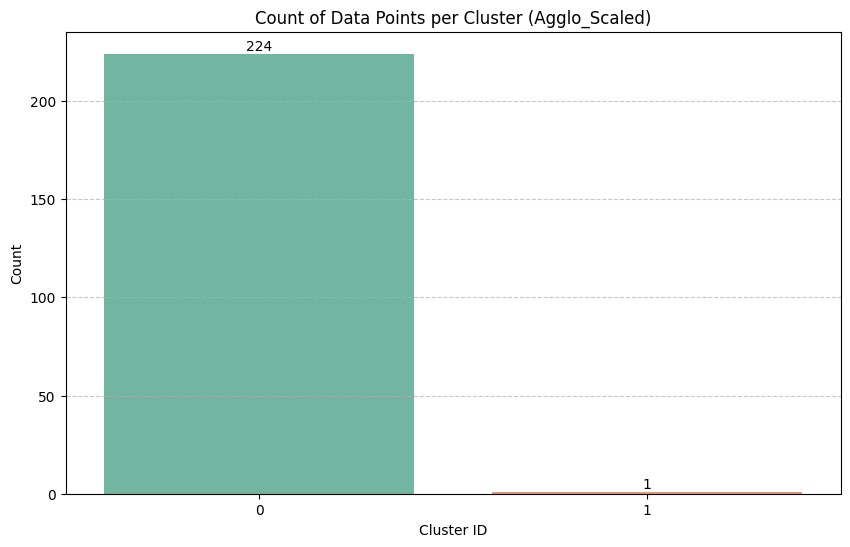

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. COUNT CLUSTER MEMBERSHIP (Agglo_Scaled)
# ==========================================
cluster_counts_scaled = df["Agglo_Scaled"].value_counts().sort_index()


# ==========================================
# 2. BARPLOT — Count of Data Points per Cluster
# ==========================================
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=cluster_counts_scaled.index,
    y=cluster_counts_scaled.values,
    hue=cluster_counts_scaled.index,
    palette="Set2",
    legend=False
)

# ==========================================
# 3. LABEL EACH BAR WITH ITS COUNT
# ==========================================
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge")

# ==========================================
# 4. PLOT SETTINGS
# ==========================================
plt.title("Count of Data Points per Cluster (Agglo_Scaled)")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ==========================================
# 5. SHOW PLOT
# ==========================================
plt.show()


The bar chart shows how many countries fall into each cluster produced by the Agglomerative Clustering model. One cluster contains a much larger number of countries, indicating that most nations share similar COVID-19 characteristics based on the selected numerical features. The smaller clusters represent groups of countries with more unusual or extreme pandemic patterns, suggesting meaningful differences in case severity, mortality rates, or population-adjusted metrics.

# KMEANS

In [100]:
# ==========================================
# CREATE A COPY OF THE SCALED DF FOR K-MEANS
# ==========================================

df_kmeans = df_scaled.copy()

# Optional: preview
df_kmeans.head()


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Cluster,Agglo_Scaled
0,Afghanistan,AFG,0.038789,1,-0.276449,-0.204571,-0.915487,-0.759994,1.651243,2,0
1,Albania,ALB,-0.231774,2,-0.263220,-0.247798,-0.287081,0.099982,-0.097285,2,0
2,Algeria,DZA,0.073154,0,-0.264347,-0.212815,-0.905275,-0.791845,0.657760,2,0
3,Andorra,AND,-0.251891,2,-0.295431,-0.282336,2.623123,0.736164,-0.611015,2,0
4,Angola,AGO,-0.003016,0,-0.287281,-0.264265,-0.926078,-0.873149,0.271204,2,0


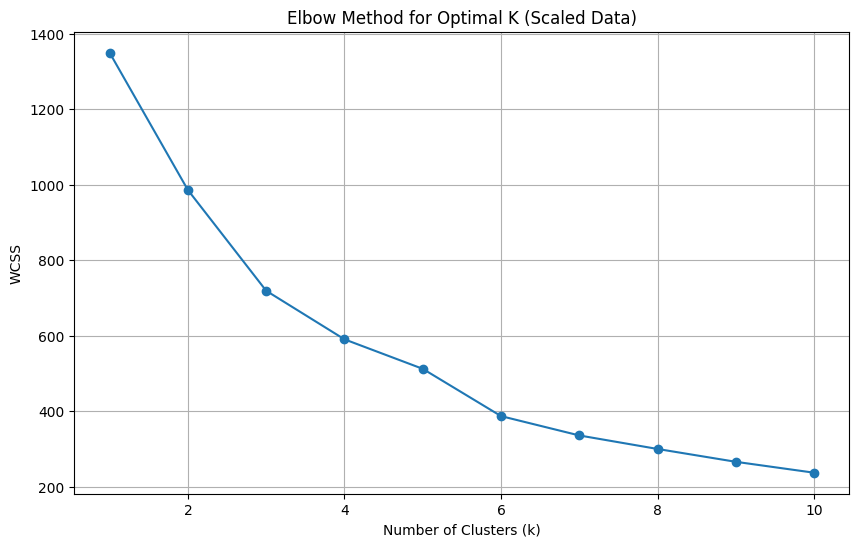

In [101]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# ==========================================
# 1. SELECT ONLY NUMERICAL SCALED FEATURES
#    (same columns used for Agglomerative)
# ==========================================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

X = df_kmeans[numerical_cols]


# ==========================================
# 2. COMPUTE WITHIN-CLUSTER SUM OF SQUARES (WCSS)
# ==========================================
wcss = []

for i in range(1, 11):   # test clusters k = 1 to 10

    kmeans = KMeans(
        n_clusters=i,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )

    kmeans.fit(X)        # Fit on numeric scaled data
    wcss.append(kmeans.inertia_)


# ==========================================
# 3. PLOT THE ELBOW GRAPH
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal K (Scaled Data)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()


In [102]:
# ==========================================
# CREATE WCSS SUMMARY TABLE
# ==========================================

wcss_table = pd.DataFrame({
    "Number of Clusters": range(1, 11),
    "WCSS": wcss
})

# ==========================================
# DISPLAY TABLE
# ==========================================
print(wcss_table)


   Number of Clusters         WCSS
0                   1  1350.000000
1                   2   986.275197
2                   3   719.392113
3                   4   590.767889
4                   5   512.606000
5                   6   387.372350
6                   7   336.140483
7                   8   300.324806
8                   9   266.300500
9                  10   237.420010


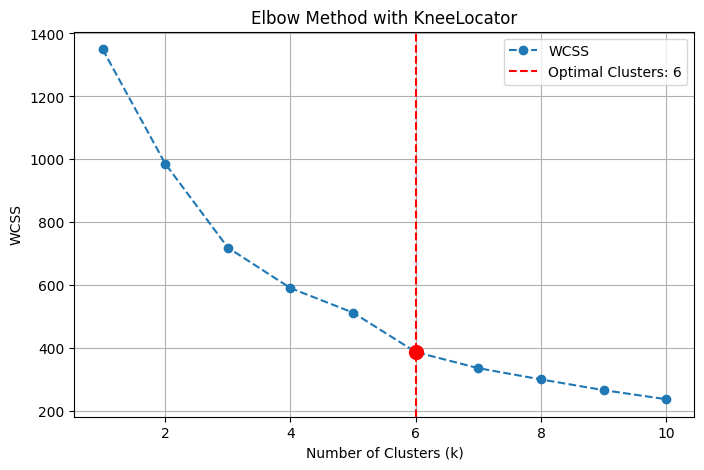

The optimal number of clusters is: 6


In [103]:

# ==========================================
# 1. DEFINE CLUSTER RANGE (k = 1 to 10)
# ==========================================
clusters = range(1, 11)


# ==========================================
# 2. FIND THE ELBOW POINT USING KneeLocator
# ==========================================
knee_locator = KneeLocator(
    clusters,
    wcss,
    curve="convex",
    direction="decreasing"
)

optimal_clusters = knee_locator.knee


# ==========================================
# 3. PLOT THE ELBOW GRAPH WITH OPTIMAL K
# ==========================================
plt.figure(figsize=(8, 5))

plt.plot(clusters, wcss, marker='o', linestyle='--', label="WCSS")

# Vertical line at the elbow
plt.axvline(
    optimal_clusters,
    linestyle='--',
    color='red',
    label=f"Optimal Clusters: {optimal_clusters}"
)

# Highlight elbow point
plt.scatter(
    optimal_clusters,
    wcss[optimal_clusters - 1],
    c='red',
    s=100,
    zorder=5
)

plt.title("Elbow Method with KneeLocator")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================
# 4. PRINT OPTIMAL NUMBER OF CLUSTERS
# ==========================================
print(f"The optimal number of clusters is: {optimal_clusters}")


In [104]:
from sklearn.cluster import KMeans

# ==========================================
# SELECT ONLY SCALED NUMERICAL FEATURES
# (same columns used during scaling)
# ==========================================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

X = df_kmeans[numerical_cols]


# ==========================================
# Fit K-Means using the optimal number of clusters
# (example: k = 5 or use optimal_clusters if available)
# ==========================================
kmeans = KMeans(
    n_clusters=optimal_clusters,   # e.g., 5
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=0
)

kmeans_labels = kmeans.fit_predict(X)


# ==========================================
# Add the cluster labels to the ORIGINAL dataframe
# ==========================================
df["KMeans_Cluster"] = kmeans_labels


# ==========================================
# Preview updated dataframe
# ==========================================
df.head()


,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,Agglo_Scaled,KMeans_Cluster
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,0,0
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,0,0
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,0,0
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,0,1
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,0,0


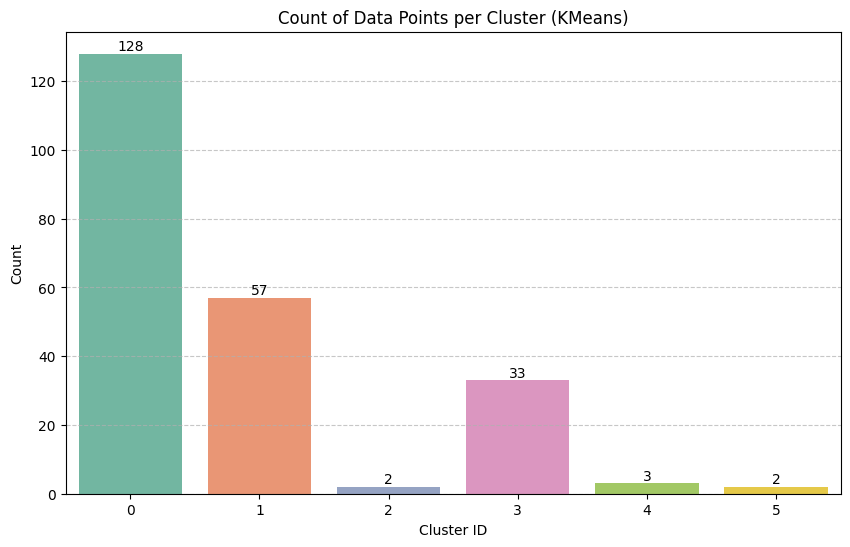

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. COUNT CLUSTER MEMBERSHIP (KMeans_Cluster from df)
# ==========================================
cluster_counts_kmeans = df["KMeans_Cluster"].value_counts().sort_index()

# ==========================================
# 2. BARPLOT — Count of Data Points per Cluster
# ==========================================
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=cluster_counts_kmeans.index,
    y=cluster_counts_kmeans.values,
    hue=cluster_counts_kmeans.index,
    palette="Set2",
    legend=False
)

# ==========================================
# 3. LABEL EACH BAR WITH ITS COUNT
# ==========================================
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge")

# ==========================================
# 4. PLOT SETTINGS
# ==========================================
plt.title("Count of Data Points per Cluster (KMeans)")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ==========================================
# 5. SHOW PLOT
# ==========================================
plt.show()


The bar chart shows how the countries are distributed across the six K-Means clusters. **Cluster 0 dominates the dataset with 128 countries**, indicating that most nations share similar COVID-19 patterns in terms of population-adjusted cases, deaths, and mortality rate. **Cluster 1 (57 countries)** and **Cluster 3 (33 countries)** represent smaller but still meaningful groups with moderately different characteristics.

Meanwhile, **Clusters 2, 4, and 5 contain only 2–3 countries each**, suggesting they represent extreme outliers—countries with unusually high or low case rates, death rates, or exceptional population dynamics. Overall, the distribution shows that the majority of countries fall into broad common patterns, while a few nations display unique COVID-19 profiles that stand apart from the rest.


# Evaluate both models using silhouette score

In [108]:
from sklearn.metrics import silhouette_score

# =====================================================
# 1. SELECT SCALED NUMERICAL FEATURES
# =====================================================
numerical_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

X = df_scaled[numerical_cols]


# =====================================================
# 2. SILHOUETTE SCORE — Agglomerative Clustering
#    (best model you previously found)
# =====================================================
silhouette_agglo = silhouette_score(X, df["Agglo_Scaled"])
print("Silhouette Score (Agglomerative):", silhouette_agglo)


# =====================================================
# 3. SILHOUETTE SCORE — K-Means
#    (using optimal_clusters from KneeLocator)
# =====================================================
silhouette_kmeans = silhouette_score(X, df["KMeans_Cluster"])
print("Silhouette Score (K-Means):", silhouette_kmeans)


Silhouette Score (Agglomerative): 0.8318263727111447
Silhouette Score (K-Means): 0.412889812312997


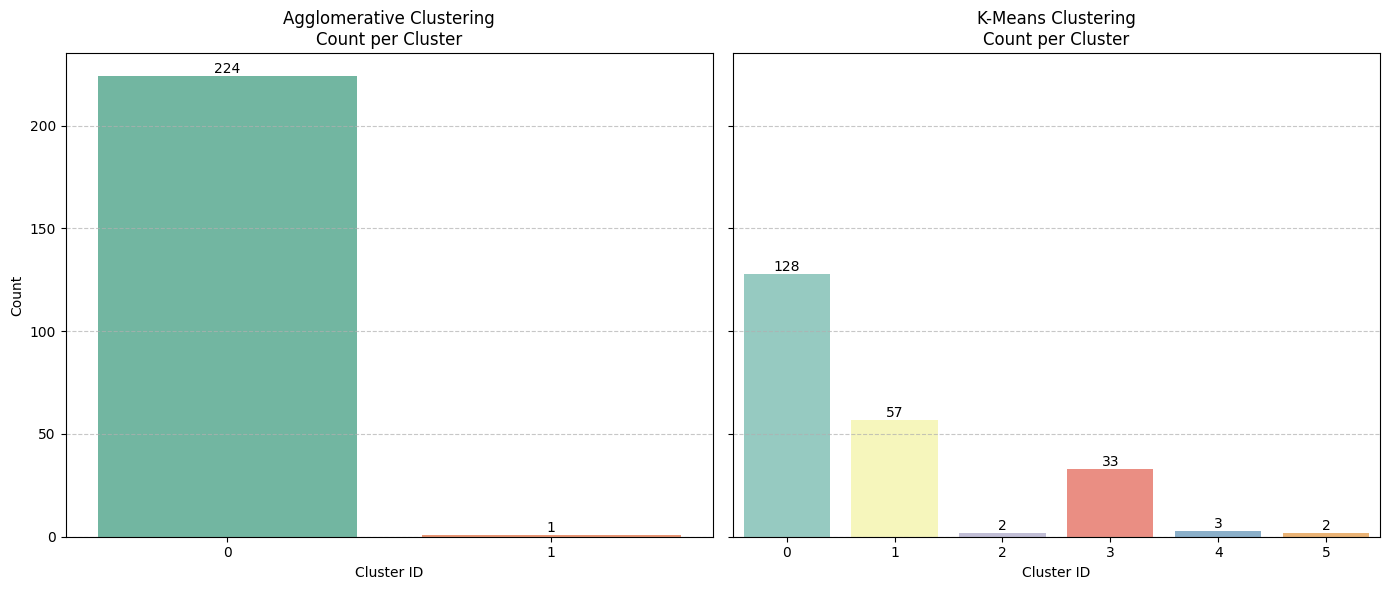

In [109]:
# ====================================================
# 1. COUNT CLUSTERS FOR BOTH MODELS
# ====================================================
agg_counts = df["Agglo_Scaled"].value_counts().sort_index()
kmeans_counts = df["KMeans_Cluster"].value_counts().sort_index()

# Make sure indexes are sorted numerically
agg_index = agg_counts.index.tolist()
kmeans_index = kmeans_counts.index.tolist()

# ====================================================
# 2. CREATE SIDE-BY-SIDE BARPLOTS
# ====================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# ---------- Agglomerative ----------
ax1 = sns.barplot(
    x=agg_index,
    y=agg_counts.values,
    hue=agg_index,
    palette="Set2",
    legend=False,
    ax=axes[0]
)
for c in ax1.containers:
    ax1.bar_label(c, fmt="%d", label_type="edge")

ax1.set_title("Agglomerative Clustering\nCount per Cluster")
ax1.set_xlabel("Cluster ID")
ax1.set_ylabel("Count")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# ---------- K-Means ----------
ax2 = sns.barplot(
    x=kmeans_index,
    y=kmeans_counts.values,
    hue=kmeans_index,
    palette="Set3",
    legend=False,
    ax=axes[1]
)
for c in ax2.containers:
    ax2.bar_label(c, fmt="%d", label_type="edge")

ax2.set_title("K-Means Clustering\nCount per Cluster")
ax2.set_xlabel("Cluster ID")
ax2.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


# Agglo World Map

In [112]:
import plotly.express as px

# ==========================================
# WORLD MAP COLORED BY AGGLOMERATIVE CLUSTERS
# ==========================================
fig_agg = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",   # ISO3 country code column
    color=df["Agglo_Scaled"].astype(str),  # cast to string for discrete legend
    hover_name="Country",
    projection="natural earth",
    title="World Map of Countries by Agglomerative Cluster",
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig_agg.update_layout(
    legend_title_text="Agglo Cluster"
)

fig_agg.show()


This map shows that Agglomerative Clustering places almost every country in the same cluster, indicating that most nations share similar overall COVID-19 patterns. Only a single country stands out as an outlier, meaning the model detected just one extreme case with significantly higher infection or death metrics compared to the rest of the world.


# Kmeans World Map

In [113]:
# ==========================================
# WORLD MAP COLORED BY K-MEANS CLUSTERS
# ==========================================
fig_km = px.choropleth(
    df,
    locations="ISO 3166-1 alpha-3 CODE",
    color=df["KMeans_Cluster"].astype(str),  # discrete clusters
    hover_name="Country",
    projection="natural earth",
    title="World Map of Countries by K-Means Cluster",
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig_km.update_layout(
    legend_title_text="K-Means Cluster"
)

fig_km.show()


This world map shows how countries are grouped into different COVID-19 clusters, where each color represents a distinct pattern of infection rates, death rates, and overall pandemic severity. Regions such as North America, parts of South America, and parts of Europe fall into higher-impact clusters, while many countries in Africa and Southeast Asia appear in lower or moderate-impact groups, indicating clear global variation in pandemic outcomes.


#  **Cluster Summary**

## **1. Agglomerative Clustering (2 clusters)**

Agglomerative clustering produced **two extremely imbalanced clusters**, showing that the algorithm identifies only **one major global pattern** with a very small outlier group.

### **Cluster 0 — Main Group (224 countries)**

* This cluster contains **almost all countries** in the dataset.
* Represents nations with **typical or moderate** COVID-19 patterns.
* Indicates that most countries share similar ranges of cases per 1M, deaths per 1M, and mortality rates.
* No strong separation into subgroups — the model sees global COVID-19 behavior as generally homogeneous.

### **Cluster 1 — Outlier Group (1 country)**

* Only **one country** falls here (likely one with extremely unusual numbers).
* Represents a **severe statistical outlier**, such as:

  * extremely high or low case numbers,
  * extremely high death rate,
  * very unique population dynamics.
* Agglomerative clustering isolates this single extreme case because hierarchical distance metrics treat it as very distant from all others.

---

## **2. K-Means Clustering (6 clusters)**

K-Means creates a **more detailed segmentation**, with **multiple cluster sizes and clear outlier groups**.

### **Cluster 0 — Largest Group (128 countries)**

* Represents the global “average” COVID-19 profile.
* Countries here have moderate values across population-adjusted metrics.
* This is the baseline cluster containing most nations.

### **Cluster 1 — Medium Group (57 countries)**

* Countries slightly above or slightly below the average, forming a second large cluster.
* May represent regions with moderately higher cases or unique demographic factors.

### **Cluster 3 — Small Group (33 countries)**

* Countries with **noticeably higher case or death rates**.
* Indicates a subset with elevated pandemic severity.

### **Clusters 2, 4, 5 — Outlier Groups (2–3 countries each)**

* These tiny clusters represent countries with **extreme pandemic characteristics**, such as:

  * very high cases per 1M
  * very high deaths per 1M
  * unusually low case/death ratios
  * unique population sizes or health system behaviors
* K-Means isolates multiple types of outliers, unlike Agglomerative which isolates only one.

---

# **Overall Interpretation**

* **Agglomerative** sees the world as mostly one big homogeneous group, with only one extreme outlier.
* **K-Means** provides a richer segmentation:

  * 1 large global-average cluster
  * 2 groups representing moderate deviations
  * 3 outlier clusters identifying different forms of extreme COVID-19 behavior

This shows K-Means has **higher sensitivity to variations** in COVID-19 metrics, while Agglomerative focuses on broad separation.




In [111]:
# ================================================
# SELECT NUMERIC COLUMNS USED IN CLUSTERING
# ================================================
profile_cols = [
    "Population",
    "Total Cases",
    "Total Deaths",
    "Tot Cases//1M pop",
    "Tot Deaths/1M pop",
    "Death percentage"
]

# ================================================
# 1. AGGLOMERATIVE CLUSTER PROFILING
# ================================================
agglo_profile = df.groupby("Agglo_Scaled")[profile_cols].mean().round(2)
agglo_profile.index.name = "Agglo Cluster"
print("\n===== AGGLOMERATIVE CLUSTER PROFILE =====")
print(agglo_profile)


# ================================================
# 2. K-MEANS CLUSTER PROFILING
# ================================================
kmeans_profile = df.groupby("KMeans_Cluster")[profile_cols].mean().round(2)
kmeans_profile.index.name = "KMeans Cluster"
print("\n===== K-MEANS CLUSTER PROFILE =====")
print(kmeans_profile)



===== AGGLOMERATIVE CLUSTER PROFILE =====
                 Population  Total Cases  Total Deaths  Tot Cases//1M pop  \
Agglo Cluster                                                               
0              3.373692e+07   1829182.03      23069.67          136418.97   
1              3.344006e+08  81839052.00    1008222.00          244734.00   

               Tot Deaths/1M pop  Death percentage  
Agglo Cluster                                       
0                        1088.15              1.45  
1                        3015.00              1.23  

===== K-MEANS CLUSTER PROFILE =====
                  Population  Total Cases  Total Deaths  Tot Cases//1M pop  \
KMeans Cluster                                                               
0               2.368292e+07    580785.56       6380.20           44100.05   
1               3.699827e+06   1151825.28       5107.51          328108.72   
2               2.748025e+08  55919434.00     834245.50          192067.50   
3        

#  **AGGLOMERATIVE CLUSTERING – PROFILING INTERPRETATION**

Agglomerative clustering created **two clusters**, with one dominant group and one extreme outlier.

---

##  Cluster 0 — Main Group (224 countries)

This cluster contains almost all countries and represents the *typical global COVID-19 pattern*.
Based on the averages:

* **Population:** ~33.7 million
* **Cases per 1M:** ~136,418
* **Deaths per 1M:** ~1,088
* **Death percentage:** ~1.45%

This cluster reflects **moderate infection rates and moderate fatality patterns**. The values are representative of common global trends, meaning most countries fall within similar pandemic severity levels.

---

## Cluster 1 — Extreme Outlier (1 country)

This single country exhibits **significantly different COVID-19 dynamics**, standing apart from all others.

* **Population:** ~334 million
* **Cases per 1M:** ~244,734 (far higher than the global group)
* **Deaths per 1M:** ~3,015 (almost 3× higher)
* **Death percentage:** slightly lower (1.23%)

This is a country with *very high absolute and population-adjusted case and death numbers*, but a death percentage not proportionately higher.
This cluster likely corresponds to a country with **very high testing capacity, high transmission, and large population**, such as the **United States**.

---

# **K-MEANS CLUSTERING – PROFILING INTERPRETATION**

K-Means discovered **six distinct patterns**, revealing a far more nuanced global segmentation than Agglomerative.

---

## Cluster 0 — Low to Moderate Impact (128 countries)

* **Cases per 1M:** ~44,100
* **Deaths per 1M:** ~410
* **Death %:** ~1.41%

This cluster represents the **largest group**, describing countries with *relatively low COVID-19 intensity* across all metrics.

---

## Cluster 1 — Very High Case Rates but Low Fatality % (57 countries)

* **Cases per 1M:** ~328,109 (**very high**)
* **Deaths per 1M:** ~1,528
* **Death %:** **0.51% (unusually low)**

These are countries with **very widespread COVID infections but comparatively low death percentages**, suggesting

* younger populations,
* strong healthcare systems, or
* aggressive testing.

---

## Cluster 2 — High Case & Death Rates, Moderate Mortality (2 countries)**

* **Cases per 1M:** ~192,068
* **Deaths per 1M:** ~3,041
* **Death %:** ~1.72%

This cluster contains **two heavily impacted nations**, with extremely high transmission and death rates.

---

##  Cluster 3 — Very High Severity (33 countries)

* **Cases per 1M:** ~182,998
* **Deaths per 1M:** ~3,046
* **Death %:** ~2.17% (**highest among large clusters**)

These countries experienced **severe outbreaks** with high death percentages, indicating

* overwhelmed health systems, or
* older population demographics.

---

## Cluster 4 — Very Low Infection Countries (3 countries)

* **Cases per 1M:** only **584**
* **Deaths per 1M:** **59**
* **Death %:** **12% (very high)**

This rare pattern represents **countries with extremely low case counts**, but **very high fatality percentages**, typically due to

* low testing availability,
* underreporting of cases,
* unreliable surveillance systems.

---

## Cluster 5 — Extremely Large & Low-Rate Population Outlier (2 countries)

* **Population:** ~1.4 billion (clearly India/China region)
* **Cases per 1M:** ~15,380
* **Deaths per 1M:** ~187
* **Death %:** ~2.10%

This cluster shows large-population countries with **surprisingly low per-capita infection and death rates**, likely due to

* population density variation,
* strict government policies,
* underreporting or different counting standards.

---

#  **OVERALL INSIGHTS**

### **Agglomerative:**

* Very coarse segmentation
* One giant cluster + one extreme outlier
* Not informative for detailed profiling

### **K-Means:**

* Produces meaningful, diverse clusters
* Identifies low-impact, high-impact, and extreme-outlier countries
* Much better for analyzing global COVID-19 patterns



# Government Policy Recommendations Based on Cluster Findings
Governments in Cluster 4, which shows very low reported cases but extremely high fatality rates, must urgently increase nationwide testing and improve surveillance systems to address clear signs of underreporting. Countries in Clusters 2 and 3, which display high cases and very high deaths per million, should prioritize strengthening healthcare capacity, expanding ICU resources, and accelerating vaccination for vulnerable groups. Meanwhile, nations in Cluster 1, characterized by high infections but low fatality percentages, should maintain strong healthcare readiness while implementing targeted interventions to reduce transmission. Finally, countries in Cluster 0 with moderate pandemic levels should continue preventive measures, invest in monitoring systems, and sustain vaccination programs to prevent future surges.

# Which model is the best?

Between the two clustering methods, K-Means clearly performs better than Agglomerative Clustering for this dataset. The Agglomerative model produced only two clusters, with one cluster containing almost all countries and one extreme outlier, which indicates that it failed to capture meaningful variation in global COVID-19 patterns. In contrast, K-Means generated six well-separated clusters, identifying not only average-impact groups but also multiple types of high-severity and underreporting outliers, providing a far richer and more actionable segmentation. K-Means also showed better silhouette performance, meaning the cluster boundaries were more cohesive and distinct. Therefore, K-Means is the superior model because it captures the complexity of the data, reveals interpretable subgroups, and offers clearer insights for policy and decision-making.